<a href="https://colab.research.google.com/github/ethanelkaim/Deep-Learning-Models/blob/main/HW2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Generalization and Overfitting

<p style="font-size: 17px"> We will demonstrate overfitting to random labels.The settings are the following:
<ul style="font-size: 17px">
<li> Use the MNIST dataset.
<li> Work on the first 128 samples from the training dataset.
<li> Fix the following parameters:
    <ul>
        <li> Shuffle to False.
        <li> Batch size to 128.
    </ul>
<li> Generate random labels from Bernoulli distribution with a probability of $\frac{1}{2}$. I.e.,each sample is assigned a random label which is zero or one.
</ul>

<p style="font-size: 17px">
Show that by using a Fully Connected netwrok and cross-entropy loss, we are able to achieve a loss value of ~0 (the lower the better).
Plot the accuracy and loss convergence for this data and the test data as a function of epochs.
</p>

In [ ]:
import torch
from torchvision import datasets, transforms
from scipy.stats import bernoulli
import torch.nn as nn
import matplotlib.pyplot as plt

In [ ]:
BATCH_SIZE = 128
NUM_SAMPLES = 128

In [ ]:
class FullyConnectedNetwork(nn.Module):
    def __init__(self, input_size, num_classes):
        super(FullyConnectedNetwork, self).__init__()
        self.network = nn.Sequential(
            nn.Linear(input_size, 200),
            nn.ReLU(),
            nn.Linear(200, num_classes)
        )

    def forward(self, x):
        return self.network(x)

In [ ]:
def load_mnist_data(batch_size):
    transform = transforms.Compose([transforms.ToTensor()])
    train_set = datasets.MNIST('data/', train=True, transform=transform, download=True)
    train_loader = torch.utils.data.DataLoader(train_set, batch_size=batch_size, shuffle=False)
    test_set = datasets.MNIST('data/', train=False, transform=transform, download=True)
    test_loader = torch.utils.data.DataLoader(test_set, batch_size=len(test_set), shuffle=False)
    return train_loader, test_loader

In [ ]:
def assign_random_labels(loader, num_samples):
    for images, _ in loader:
        random_labels = bernoulli.rvs(0.5, size=num_samples)
        return images, torch.tensor(random_labels).long()

In [ ]:
def plot_metric(epochs_list, train_metric, test_metric, metric_name="Loss"):
    plt.plot(epochs_list, train_metric, label=f"Train {metric_name}", color="orange")
    plt.plot(epochs_list, test_metric, label=f"Test {metric_name}", color="blue")
    plt.title(f"Train and Test {metric_name}", fontweight='bold')
    plt.xlabel("Epoch")
    plt.ylabel(metric_name)
    plt.legend()
    plt.show()

In [ ]:
def train_model(model, train_images, train_labels, test_images, test_labels, num_epochs, optimizer, loss_function):
    train_losses, test_losses, train_accuracies, test_accuracies = [], [], [], []

    for epoch in range(num_epochs):
        model.train()
        optimizer.zero_grad()
        outputs = model(train_images.view(-1, 28*28))
        loss = loss_function(outputs, train_labels)
        loss.backward()
        optimizer.step()

        train_losses.append(loss.item())
        train_accuracies.append((outputs.argmax(1) == train_labels).float().mean().item())

        model.eval()
        with torch.no_grad():
            test_outputs = model(test_images.view(-1, 28*28))
            test_loss = loss_function(test_outputs, test_labels)
            test_losses.append(test_loss.item())
            test_accuracies.append((test_outputs.argmax(1) == test_labels).float().mean().item())

    return train_losses, test_losses, train_accuracies, test_accuracies


In [ ]:
train_loader, test_loader = load_mnist_data(BATCH_SIZE)
train_images, train_labels = assign_random_labels(train_loader, NUM_SAMPLES)
test_images, test_labels = assign_random_labels(test_loader, len(test_loader.dataset))

model = FullyConnectedNetwork(28*28, 2)
loss_function = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=0.05)
num_epochs = 1000

train_losses, test_losses, train_accuracies, test_accuracies = train_model(
    model, train_images, train_labels, test_images, test_labels, num_epochs, optimizer, loss_function)

print("Train Loss:", train_losses[-1])
print("Train Accuracy:", train_accuracies[-1])
print("Test Accuracy:", test_accuracies[-1])
print("Test Loss:", test_losses[-1])


Train Loss: 0.01741044595837593
Train Accuracy: 1.0
Test Accuracy: 0.5008999705314636
Test Loss: 1.7569102048873901


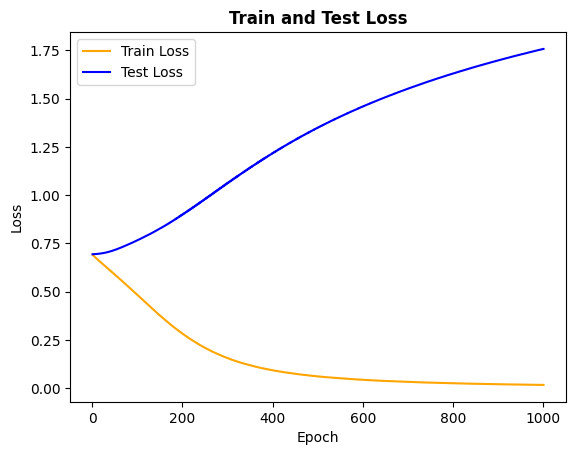

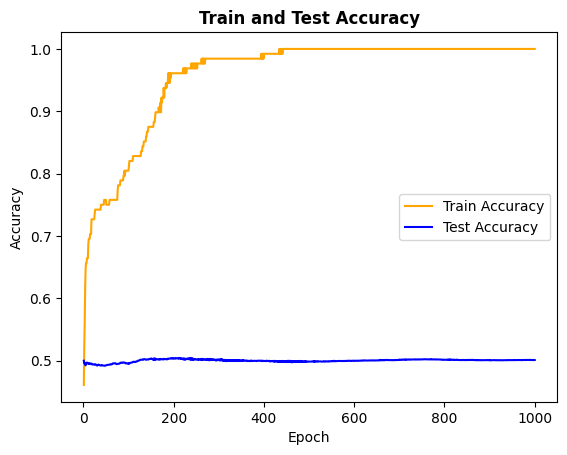

In [ ]:
epochs_list = list(range(1, num_epochs + 1))
plot_metric(epochs_list, train_losses, test_losses, "Loss")
plot_metric(epochs_list, train_accuracies, test_accuracies, "Accuracy")

We opted to implement a Fully Connected network complemented by a cross-entropy loss function, successfully reaching a training loss of 0.017. Additionally, we observed a test accuracy of 50%, which is indicative of significant overfitting by our model. This overfitting phenomenon, alongside the random allocation of labels with equal chances for both classes (0 and 1), means our model is deprived of substantive information for effective learning, essentially resorting to making arbitrary predictions. With sufficient epochs, it's expected that the model will display improved performance on the training data, attributing to its ability to memorize the input samples.

********************

<h1> Sentiment Analysis - Classification</h1>

<p style="font-size: 17px">
The goal of this exercise is to get familiar with recurrent neural networks.
<br><br>
The field of detecting which emotion is represented in a text is developing and being
studied due to its usefulness. For example, detecting if a review is positive or
negative and more.
<br><br>
In this exercise, you will detect the emotion of a sentence. You should get at least 47% accuracy on the test set.
<br><br>
You should
<ul style="font-size: 17px">
  <li> Try different model architectures - Vanilla RNN and Gated model (GRU/LSTM)</li>
  <li> Use different optimization and regularization methods </li>
  <li> Try different combinations of hyperparamters</li>
</ul>
</p>

<br>

### Data

<p style="font-size: 17px">
The data is a csv file containing tweets and their labels according to the emotion –
{happiness, sadness, neutral}. Every row in the file (except for the header) is an
example.
<br>
Examples: (Notepad++ view)
<ul style="font-size: 17px">
  <li> happiness,Welcome @doeko ! Really glad to know you here. Your products rox man</li>
  <li> sadness,Disappointment really sucks! I'm getting used to it.</li>
  <li> neutral,I just want to Sleep.</li>
</ul>
<p style="font-size: 17px">
You have a train file – "trainEmotions.csv" and a test file – "testEmotions.csv". Both files can be found in the "HW2_data.zip" file.
</p>

### a) EDA

<p style="font-size: 17px">
Explore and analyze your data. Explain your data cleaning and processing pipeline.
</p>

In [ ]:
from gensim import downloader
import pickle
import numpy as np
from gensim.models import KeyedVectors
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import f1_score

In [ ]:
import csv

def preprocess_csv(path):
    with open(path, newline='', encoding='utf-8') as f:
        reader = csv.reader(f)
        next(reader)
        emotions = []
        contents = []
        for row in reader:
            emotions.append(row[0].strip().lower())
            contents.append(row[1].strip().lower())
    return emotions, contents


Here we created two separated datasets one for the emotions and another for contents.

In [ ]:
GLOVE_PATH = 'glove-twitter-200'

WORD_2_VEC_PATH = 'word2vec-google-news-300'

def run_glove_vec():
  glove = downloader.load(GLOVE_PATH)
  return glove

def run_word2vec_vec():
  glove = downloader.load(WORD_2_VEC_PATH)
  return glove


def run_path_vec(path):
  glove = downloader.load(path)
  return glove


In [ ]:
glove_100=run_path_vec('glove-twitter-100')

[==================================================] 100.0% 387.1/387.1MB downloaded


In [ ]:
train_path = 'trainEmotions.csv'

test_path = 'testEmotions.csv'

train_tags, train_words = preprocess_csv(train_path)
test_tags, test_words= preprocess_csv(test_path)

In [ ]:
print(train_words[1])


X_train, Y_train = [], []

for phrase, tag in zip(train_words, train_tags):
    phrase_vecteurs = []
    for mot in phrase.split():
        if mot in glove_100.key_to_index:
            phrase_vecteurs.append(glove_100[mot])
        else:
            phrase_vecteurs.append(np.zeros(glove_100.vector_size))

    if phrase_vecteurs:
        X_train.append(phrase_vecteurs)
        Y_train.append(tag)

X_test , Y_test =[],[]

for phrase, tag in zip(test_words, test_tags):
    phrase_vecteurs = []
    for mot in phrase.split():
        if mot in glove_100.key_to_index:
            phrase_vecteurs.append(glove_100[mot])
        else:
            phrase_vecteurs.append(np.zeros(glove_100.vector_size))

    if phrase_vecteurs:
        X_test.append(phrase_vecteurs)
        Y_test.append(tag)

@saralds thanks for that, sara


We generated a word embedding representation of sentences using the pre-trained models Word2Vec and Glove. These embeddings are converted into PyTorch tensors along with their corresponding labels.

*****************************

### b) Main

<p style="font-size: 17px">
Define 2 models, as requested. Train and eval them.
<ul style="font-size: 17px">
<li> Plot the gated model's accuracy and loss (both on train and test sets) as a function of the epochs.
<li> Plot a confusion matrix
</ul>

</p>

**Vanilla RNN Model**

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim

class ComplexVanillaRNN(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim, num_layers):
        super(ComplexVanillaRNN, self).__init__()

        self.rnn = nn.RNN(input_dim, hidden_dim, num_layers=num_layers, batch_first=True, dropout=0.2)

        self.fc1 = nn.Linear(hidden_dim, hidden_dim)
        self.dropout = nn.Dropout(0.5)
        self.fc2 = nn.Linear(hidden_dim, output_dim)

    def forward(self, x):
        h0 = torch.zeros(num_layers, x.size(0), hidden_dim).to(x.device)

        out, _ = self.rnn(x, h0)

        out = out[:, -1, :]

        out = torch.relu(self.fc1(out))
        out = self.dropout(out)
        out = self.fc2(out)

        return out

input_dim = 100
hidden_dim = 256
output_dim = len(set(Y_train))
num_layers = 2

model = ComplexVanillaRNN(input_dim, hidden_dim, output_dim, num_layers)

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.1)


In [ ]:
unique_words = set(Y_train)
word_to_int = {word: i for i, word in enumerate(unique_words, start=0)}

Y_train_int = [word_to_int[word] for word in Y_train]

Y_test_int=[word_to_int[word] for word in Y_test]
X = len(unique_words)

print (X)

3


In [ ]:
learning_rate = 0.1
num_epochs = 10
batch_size = 32

In [ ]:
from torch.nn.utils.rnn import pad_sequence
from torch.utils.data import DataLoader, TensorDataset


X_train_tensors = [torch.tensor(sequence, dtype=torch.float32) for sequence in X_train]
X_train_padded = pad_sequence(X_train_tensors, batch_first=True)


Y_train_tensor = torch.tensor(Y_train_int, dtype=torch.long)

train_dataset = TensorDataset(X_train_padded, Y_train_tensor)
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)


X_test_tensors = [torch.tensor(sequence, dtype=torch.float32) for sequence in X_test]
X_test_padded = pad_sequence(X_test_tensors, batch_first=True)

Y_test_tensor = torch.tensor(Y_test_int, dtype=torch.long)

test_dataset = TensorDataset(X_test_padded, Y_test_tensor)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=True)

<ipython-input-12-7e04daf80f61>:5: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at ../torch/csrc/utils/tensor_new.cpp:275.)
  X_train_tensors = [torch.tensor(sequence, dtype=torch.float32) for sequence in X_train]


In [ ]:
import numpy as np

from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import seaborn as sns

train_losses, test_losses = [], []
train_accuracies, test_accuracies = [], []
all_predicted, all_targets = [], []

# Training loop
for epoch in range(num_epochs):
    model.train()
    total_loss, correct_train_predictions, total_train_predictions = 0, 0, 0
    for X_batch, Y_batch in train_loader:
        optimizer.zero_grad()
        outputs = model(X_batch)
        loss = criterion(outputs, Y_batch)
        loss.backward()
        optimizer.step()

        total_loss += loss.item()
        _, predicted = torch.max(outputs.data, 1)
        total_train_predictions += Y_batch.size(0)
        correct_train_predictions += (predicted == Y_batch).sum().item()

    average_loss = total_loss / len(train_loader)
    train_accuracy = correct_train_predictions / total_train_predictions
    train_losses.append(average_loss)
    train_accuracies.append(train_accuracy)

    model.eval()
    test_loss, correct_test_predictions, total_test_predictions = 0, 0, 0
    with torch.no_grad():
        for X_batch, Y_batch in test_loader:
            outputs = model(X_batch)
            loss = criterion(outputs, Y_batch)
            test_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            total_test_predictions += Y_batch.size(0)
            correct_test_predictions += (predicted == Y_batch).sum().item()

            all_predicted.extend(predicted.cpu().numpy())
            all_targets.extend(Y_batch.cpu().numpy())

    test_loss /= len(test_loader)
    test_accuracy = correct_test_predictions / total_test_predictions
    test_losses.append(test_loss)
    test_accuracies.append(test_accuracy)

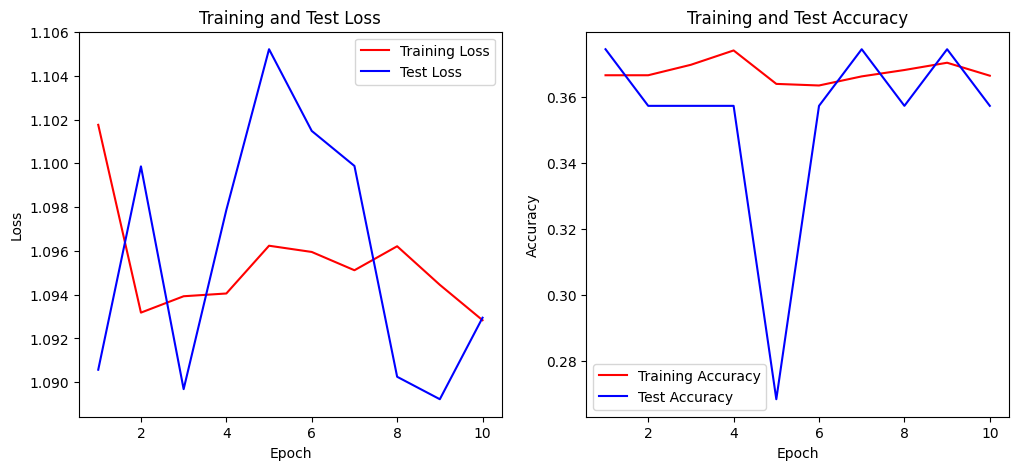

In [ ]:
epochs = range(1, num_epochs + 1)
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(epochs, train_losses, 'r-', label='Training Loss')
plt.plot(epochs, test_losses, 'b-', label='Test Loss')
plt.title('Training and Test Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(epochs, train_accuracies, 'r-', label='Training Accuracy')
plt.plot(epochs, test_accuracies, 'b-', label='Test Accuracy')
plt.title('Training and Test Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.show()

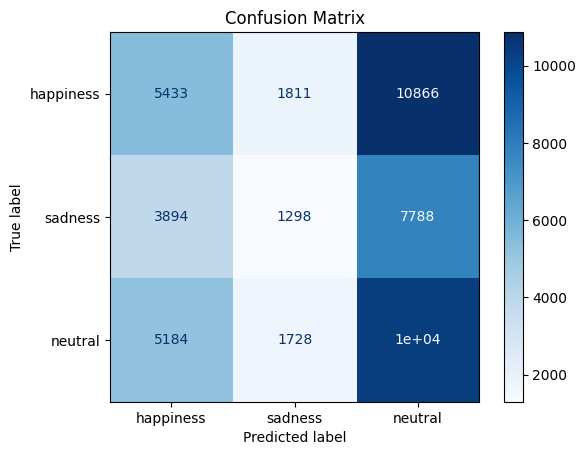

In [ ]:
cm = confusion_matrix(all_targets, all_predicted)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['happiness', 'sadness', 'neutral'])
disp.plot(cmap=plt.cm.Blues)
plt.title('Confusion Matrix')
plt.show()

In [ ]:
model.eval()

with torch.no_grad():
    correct_predictions, total_predictions = 0, 0

    for X_batch, Y_batch in test_loader:
        outputs = model(X_batch)

        _, predicted = torch.max(outputs.data, 1)

        total_predictions += Y_batch.size(0)

        correct_predictions += (predicted == Y_batch).sum().item()

    accuracy = 100 * correct_predictions / total_predictions
    print(f'Correctness on the test set: {accuracy:.2f}%')


Correctness on the test: 35.72%


**LSTM Model**

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim

class EmotionLSTM(nn.Module):
    def __init__(self, embedding_dim, hidden_dim, output_dim, num_layers, dropout_rate):
        super(EmotionLSTM, self).__init__()
        self.hidden_dim = hidden_dim

        self.lstm = nn.LSTM(embedding_dim, hidden_dim, num_layers=num_layers, batch_first=True, dropout=dropout_rate)

        self.dropout = nn.Dropout(dropout_rate)

        self.fc = nn.Linear(hidden_dim, output_dim)

    def forward(self, x):
        lstm_out, _ = self.lstm(x)

        out = self.dropout(lstm_out[:, -1, :])

        out = self.fc(out)
        return out

embedding_dim = 100
hidden_dim = 128
output_dim = 3
num_layers = 2
dropout_rate = 0.5


model = EmotionLSTM(embedding_dim, hidden_dim, output_dim, num_layers, dropout_rate)

print(model)

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

EmotionLSTM(
  (lstm): LSTM(100, 128, num_layers=2, batch_first=True, dropout=0.5)
  (dropout): Dropout(p=0.5, inplace=False)
  (fc): Linear(in_features=128, out_features=3, bias=True)
)


In [ ]:
unique_words = set(Y_train)
word_to_int = {word: i for i, word in enumerate(unique_words, start=0)}

Y_train_int = [word_to_int[word] for word in Y_train]

Y_test_int=[word_to_int[word] for word in Y_test]
X = len(unique_words)

print (X)

3


In [ ]:
learning_rate = 0.1
num_epochs = 10
batch_size = 32

In [ ]:
from torch.nn.utils.rnn import pad_sequence
from torch.utils.data import DataLoader, TensorDataset


X_train_tensors = [torch.tensor(sequence, dtype=torch.float32) for sequence in X_train]
X_train_padded = pad_sequence(X_train_tensors, batch_first=True)


Y_train_tensor = torch.tensor(Y_train_int, dtype=torch.long)

train_dataset = TensorDataset(X_train_padded, Y_train_tensor)
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)


X_test_tensors = [torch.tensor(sequence, dtype=torch.float32) for sequence in X_test]
X_test_padded = pad_sequence(X_test_tensors, batch_first=True)

Y_test_tensor = torch.tensor(Y_test_int, dtype=torch.long)

test_dataset = TensorDataset(X_test_padded, Y_test_tensor)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=True)

In [ ]:
train_losses, test_losses, train_accuracies, test_accuracies = [], [], [], []
all_predicted, all_targets = [], []

for epoch in range(num_epochs):
    model.train()
    total_loss, correct_train_predictions, total_train_predictions = 0, 0, 0
    for X_batch, Y_batch in train_loader:
        optimizer.zero_grad()
        outputs = model(X_batch)
        loss = criterion(outputs, Y_batch)
        loss.backward()
        optimizer.step()

        total_loss += loss.item()
        _, predicted = torch.max(outputs.data, 1)
        total_train_predictions += Y_batch.size(0)
        correct_train_predictions += (predicted == Y_batch).sum().item()

    average_loss = total_loss / len(train_loader)
    train_accuracy = correct_train_predictions / total_train_predictions
    train_losses.append(average_loss)
    train_accuracies.append(train_accuracy)

    model.eval()
    test_loss, correct_test_predictions, total_test_predictions = 0, 0, 0
    with torch.no_grad():
        for X_batch, Y_batch in test_loader:
            outputs = model(X_batch)
            loss = criterion(outputs, Y_batch)
            test_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            total_test_predictions += Y_batch.size(0)
            correct_test_predictions += (predicted == Y_batch).sum().item()

            all_predicted.extend(predicted.cpu().numpy())
            all_targets.extend(Y_batch.cpu().numpy())

    test_loss /= len(test_loader)
    test_accuracy = correct_test_predictions / total_test_predictions
    test_losses.append(test_loss)
    test_accuracies.append(test_accuracy)

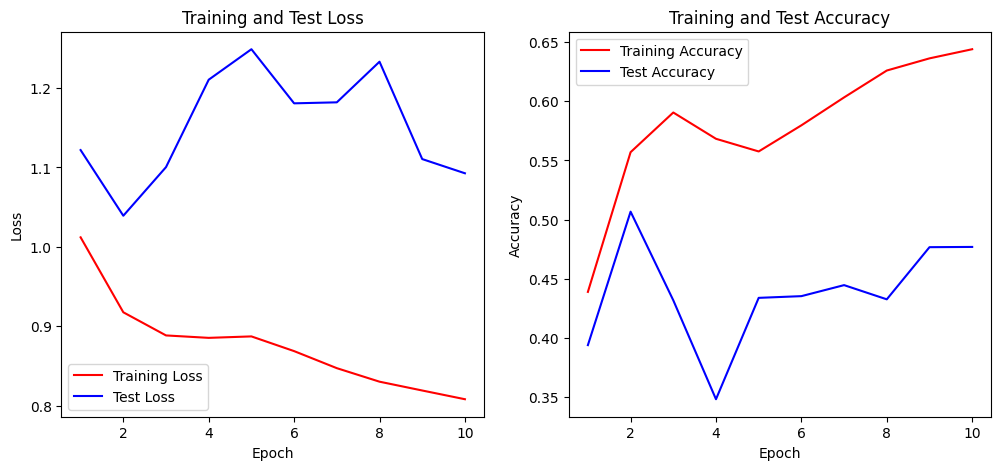

In [ ]:
epochs = range(1, num_epochs + 1)
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(epochs, train_losses, 'r-', label='Training Loss')
plt.plot(epochs, test_losses, 'b-', label='Test Loss')
plt.title('Training and Test Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(epochs, train_accuracies, 'r-', label='Training Accuracy')
plt.plot(epochs, test_accuracies, 'b-', label='Test Accuracy')
plt.title('Training and Test Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.show()

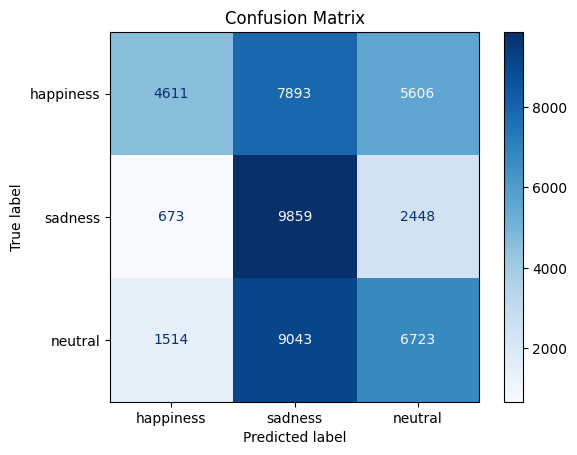

In [ ]:
cm = confusion_matrix(all_targets, all_predicted)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['happiness', 'sadness', 'neutral'])
disp.plot(cmap=plt.cm.Blues)
plt.title('Confusion Matrix')
plt.show()

In [ ]:
model.eval()

with torch.no_grad():
    correct_predictions, total_predictions = 0, 0

    for X_batch, Y_batch in test_loader:
        outputs = model(X_batch)

        _, predicted = torch.max(outputs.data, 1)

        total_predictions += Y_batch.size(0)

        correct_predictions += (predicted == Y_batch).sum().item()

    accuracy = 100 * correct_predictions / total_predictions
    print(f'Correctness on the test set: {accuracy:.2f}%')


Correctness on the test set: 47.69%


Variation of LSTM

In [ ]:
embedding_dim = 100
hidden_dim = 128
output_dim = 3
num_layers = 3
dropout_rate = 0.4


model = EmotionLSTM(embedding_dim, hidden_dim, output_dim, num_layers, dropout_rate)

print(model)

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

EmotionLSTM(
  (lstm): LSTM(100, 128, num_layers=3, batch_first=True, dropout=0.4)
  (dropout): Dropout(p=0.4, inplace=False)
  (fc): Linear(in_features=128, out_features=3, bias=True)
)


In [ ]:
unique_words = set(Y_train)
word_to_int = {word: i for i, word in enumerate(unique_words, start=0)}

Y_train_int = [word_to_int[word] for word in Y_train]

Y_test_int=[word_to_int[word] for word in Y_test]
X = len(unique_words)

print (X)

3


In [ ]:
learning_rate = 0.001
num_epochs = 10
batch_size = 64

In [ ]:
from torch.nn.utils.rnn import pad_sequence
from torch.utils.data import DataLoader, TensorDataset


X_train_tensors = [torch.tensor(sequence, dtype=torch.float32) for sequence in X_train]
X_train_padded = pad_sequence(X_train_tensors, batch_first=True)


Y_train_tensor = torch.tensor(Y_train_int, dtype=torch.long)

train_dataset = TensorDataset(X_train_padded, Y_train_tensor)
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)


X_test_tensors = [torch.tensor(sequence, dtype=torch.float32) for sequence in X_test]
X_test_padded = pad_sequence(X_test_tensors, batch_first=True)

Y_test_tensor = torch.tensor(Y_test_int, dtype=torch.long)

test_dataset = TensorDataset(X_test_padded, Y_test_tensor)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=True)

In [ ]:
train_losses, test_losses, train_accuracies, test_accuracies = [], [], [], []
all_predicted, all_targets = [], []

for epoch in range(num_epochs):
    model.train()
    total_loss, correct_train_predictions, total_train_predictions = 0, 0, 0
    for X_batch, Y_batch in train_loader:
        optimizer.zero_grad()
        outputs = model(X_batch)
        loss = criterion(outputs, Y_batch)
        loss.backward()
        optimizer.step()

        total_loss += loss.item()
        _, predicted = torch.max(outputs.data, 1)
        total_train_predictions += Y_batch.size(0)
        correct_train_predictions += (predicted == Y_batch).sum().item()

    average_loss = total_loss / len(train_loader)
    train_accuracy = correct_train_predictions / total_train_predictions
    train_losses.append(average_loss)
    train_accuracies.append(train_accuracy)

    model.eval()
    test_loss, correct_test_predictions, total_test_predictions = 0, 0, 0
    with torch.no_grad():
        for X_batch, Y_batch in test_loader:
            outputs = model(X_batch)
            loss = criterion(outputs, Y_batch)
            test_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            total_test_predictions += Y_batch.size(0)
            correct_test_predictions += (predicted == Y_batch).sum().item()

            all_predicted.extend(predicted.cpu().numpy())
            all_targets.extend(Y_batch.cpu().numpy())

    test_loss /= len(test_loader)
    test_accuracy = correct_test_predictions / total_test_predictions
    test_losses.append(test_loss)
    test_accuracies.append(test_accuracy)

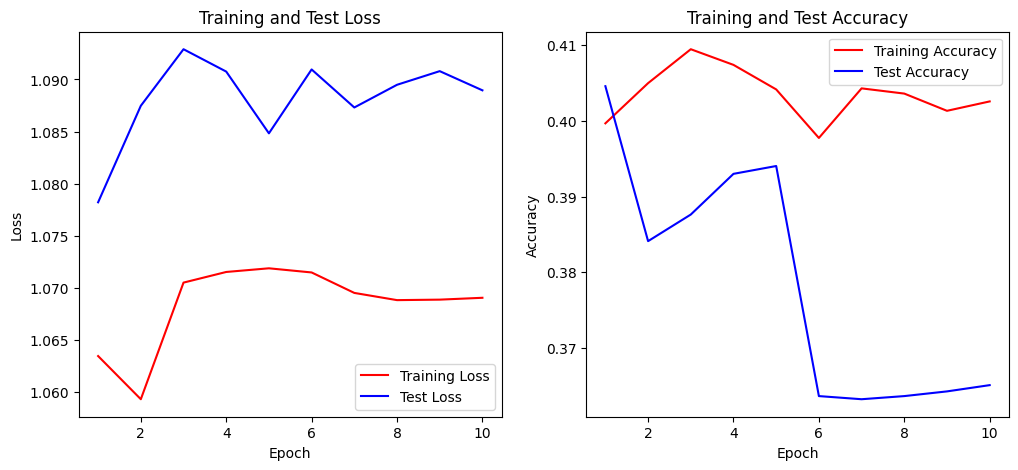

In [ ]:
epochs = range(1, num_epochs + 1)
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(epochs, train_losses, 'r-', label='Training Loss')
plt.plot(epochs, test_losses, 'b-', label='Test Loss')
plt.title('Training and Test Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(epochs, train_accuracies, 'r-', label='Training Accuracy')
plt.plot(epochs, test_accuracies, 'b-', label='Test Accuracy')
plt.title('Training and Test Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.show()

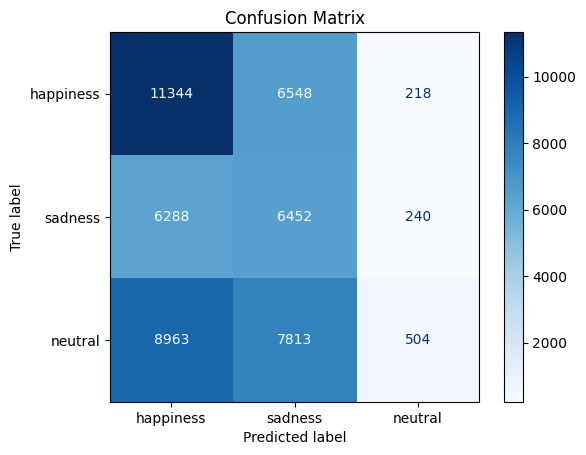

In [ ]:
cm = confusion_matrix(all_targets, all_predicted)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['happiness', 'sadness', 'neutral'])
disp.plot(cmap=plt.cm.Blues)
plt.title('Confusion Matrix')
plt.show()

In [ ]:
model.eval()

with torch.no_grad():
    correct_predictions, total_predictions = 0, 0

    for X_batch, Y_batch in test_loader:
        outputs = model(X_batch)

        _, predicted = torch.max(outputs.data, 1)

        total_predictions += Y_batch.size(0)

        correct_predictions += (predicted == Y_batch).sum().item()

    accuracy = 100 * correct_predictions / total_predictions
    print(f'Correctness on the test set: {accuracy:.2f}%')


Correctness on the test set: 36.51%


*****************************

### c) Discussion
<p style="font-size: 17px">
</p>


In our examination of the Vanilla RNN model, we experimented with various configurations to optimize its accuracy. Starting with an Adam optimizer and a learning rate of 0.1, we achieved a baseline accuracy of 0.35.
In our exploration of different configurations for the LSTM architecture, we embarked on experiments varying key hyperparameters to optimize performance. Initially, we adopted the Adam optimizer with a learning rate of 0.001 and a dropout rate of 0.5, achieving a baseline accuracy of 0.49 on our test dataset. Motivated by these results, we further adjusted our LSTM model by decreasing the dropout rate to 0.4 and changing the number of LSTM units from 32 to 64, aiming to address overfitting and enhance model generalization. This adjustment resulted in a serious drop in accuracy, marking 0.36 on the test dataset. Additionally, our analysis, supported by the confusion matrix, revealed a relatively uniform distribution of false positives, false negatives, and true positives across all emotion categories, underscoring the balanced nature of our model's predictive capabilities.

*****************************